## Descargar datos
https://www.kaggle.com/mchirico/philadelphiacrimedata

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('crime.csv')

In [3]:
data.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800.0,Other Assaults,NaN,2009-10,NaN,NaN
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600.0,All Other Offenses,NaN,2009-05,NaN,NaN
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800.0,Other Assaults,NaN,2009-08,NaN,NaN
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500.0,Weapon Violations,20.0,2009-07,-75.130477,40.036389
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532


## ¿Cuáles crimenes se cometieron?

In [4]:
crimes = data['Text_General_Code'].value_counts()
crimes

All Other Offenses                         437581
Other Assaults                             277332
Thefts                                     257923
Vandalism/Criminal Mischief                200345
Theft from Vehicle                         171135
Narcotic / Drug Law Violations             137448
Fraud                                      114416
Recovered Stolen Motor Vehicle              95282
Burglary Residential                        94143
Aggravated Assault No Firearm               68989
DRIVING UNDER THE INFLUENCE                 53721
Robbery No Firearm                          51919
Motor Vehicle Theft                         46517
Robbery Firearm                             40577
Disorderly Conduct                          40137
Aggravated Assault Firearm                  27934
Burglary Non-Residential                    23276
Weapon Violations                           19092
Other Sex Offenses (Not Commercialized)     15304
Prostitution and Commercialized Vice        12854


## ¿Cuál fue el crimen más y menos cometido?

In [5]:
max_crime = crimes.index[0]
min_crime = crimes.index[len(crimes)-1]
print('Más: ', max_crime)
print('Menos: ', min_crime)

Más:  All Other Offenses
Menos:  Homicide - Gross Negligence


## ¿En qué lugares ocurrió el crimen menos cometido? 

In [6]:
min_crime_locations = data[data['Text_General_Code'] == min_crime]['Location_Block'].unique()
list(min_crime_locations)

['2200 BLOCK RHAWN ST',
 '6600 BLOCK N 8TH ST',
 '2100 BLOCK MARKET ST',
 'N BROAD ST  / W GLENWOOD AV',
 '500 BLOCK SENTNER ST',
 '2700 BLOCK RHAWN ST',
 '0 BLOCK E WALNUT LN']

## ¿A qué horas ocurrieron los crimenes?

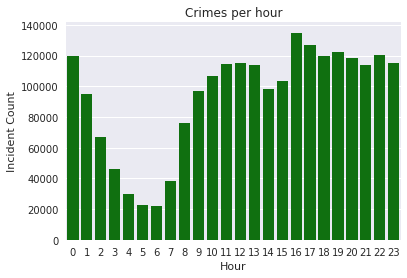

In [7]:
sns.set()
sns.countplot(data['Hour'], color='green')
plt.title("Crimes per hour")
plt.xlabel("Hour")
plt.ylabel("Incident Count")
plt.show()

## ¿Cuáles son las horas y distritos con más crimenes?

### Eliminar las columnas innecesarias

In [8]:
columns = set(data)
columns = columns - set(['Hour', 'Dc_Dist'])

hour_district = data.drop(columns, axis=1)

### Contar los crimenes por hora y distrito

In [9]:
hour_district['Occurrences'] = 1
hour_district = hour_district.groupby(["Dc_Dist", "Hour"]).size().reset_index(name="Occurrences")
hour_district.head()

,Dc_Dist,Hour,Occurrences
0,1,0,3060
1,1,1,2186
2,1,2,1539
3,1,3,1176
4,1,4,795


### Graficar

In [10]:
hour_district = hour_district.pivot("Dc_Dist", "Hour", "Occurrences")
hour_district.fillna(0, inplace=True)

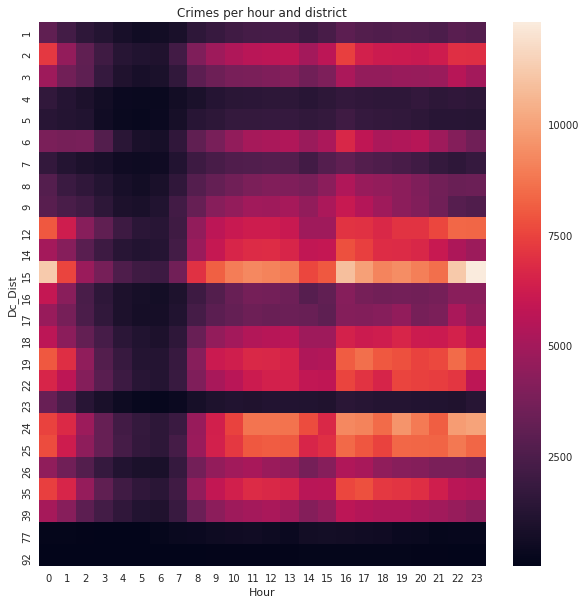

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.title("Crimes per hour and district")
ax = sns.heatmap(hour_district)
plt.show()

## ¿Cuál es la probabilidad de que un crimen ocurrido en cualquier lugar sea un homicidio?

### Transformar los crimenes de homicidio en un solo tipo

In [12]:
homicide_types = ['Homicide - Criminal', 'Homicide - Justifiable', 'Homicide - Gross Negligence']
data.loc[data['Text_General_Code'].isin(homicide_types), 'Text_General_Code'] = 'Homicide'

In [13]:
import numpy as np
from scipy.stats import beta as beta_distribution

### Hallar probabilidades 

In [14]:
num_crimes = data.shape[0]
num_crime_occurrences = data['Text_General_Code'].value_counts()['All Other Offenses']

alpha = 1 + num_crime_occurrences
beta = 1 + (num_crimes - num_crime_occurrences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

### Graficar probabilidades 

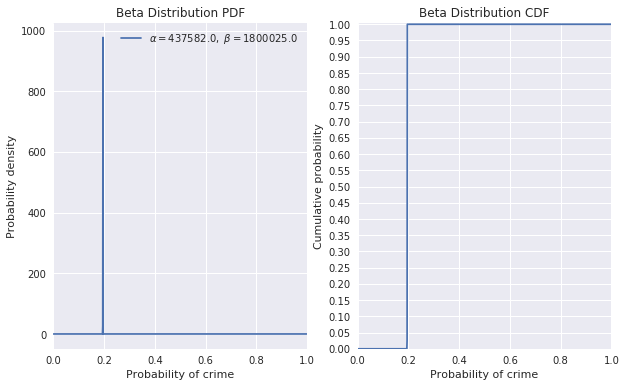

In [15]:
plt.figure(figsize=(10, 6))

# PDF
plt.subplot(121)

plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of crime')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)

# CDF
plt.subplot(122)

plt.plot(x_values, cdf_y_values)

plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of crime')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')

plt.show()

### Calcular la verdadera probabilidad 

In [16]:
percentile = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .99]
)

print('La verdadera probabilidad es: {}'.format(round(percentile, 4)))

La verdadera probabilidad es: 0.1948


## ¿Cuáles similaridades en crimenes ocurren donde hay homicidios?

### Buscar los crimenes que ocurrieron en los mismos lugares donde hubieron homicidios

In [17]:
homicide_locations = data[data['Text_General_Code'] == 'Homicide']['Location_Block']

homicides_data = data[data['Location_Block'].isin(homicide_locations)]
homicides_data.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532
18,24,2,2015-04-11 17:38:00,2015-04-11,17:38:00,17,201524030846,2800 BLOCK RUTH ST,2400.0,Disorderly Conduct,17.0,2015-04,-75.122057,39.990907
26,2,1,2015-12-08 14:42:00,2015-12-08,14:42:00,14,201502078234,4600 BLOCK E ROOSEVELT BLVD,600.0,Thefts,2.0,2015-12,-75.099584,40.028490
28,24,2,2015-08-23 01:58:00,2015-08-23,01:58:00,1,201524080438,3000 BLOCK B ST,800.0,Other Assaults,17.0,2015-08,-75.125869,39.995626
35,15,1,2015-11-13 16:51:00,2015-11-13,16:51:00,16,201515111714,1600 BLOCK DYRE ST,300.0,Robbery No Firearm,11.0,2015-11,-75.077126,40.020219


### Eliminar las columnas innecesarias 

In [18]:
columns = set(homicides_data)
columns = columns - set(['Text_General_Code', 'Location_Block'])
list(columns)

['Dispatch_Date',
 'Psa',
 'Dc_Key',
 'Hour',
 'Lat',
 'Dc_Dist',
 'UCR_General',
 'Lon',
 'Police_Districts',
 'Dispatch_Time',
 'Month',
 'Dispatch_Date_Time']

In [19]:
homicides_data = homicides_data.drop(columns, axis=1)
homicides_data.head()

,Location_Block,Text_General_Code
4,1800 BLOCK WYLIE ST,All Other Offenses
18,2800 BLOCK RUTH ST,Disorderly Conduct
26,4600 BLOCK E ROOSEVELT BLVD,Thefts
28,3000 BLOCK B ST,Other Assaults
35,1600 BLOCK DYRE ST,Robbery No Firearm


### Contar los crimenes por localización

In [20]:
homicides_data['Occurrence'] = 1
homicides_data.groupby(['Text_General_Code', 'Location_Block']).count().sort_values('Occurrence', ascending=False)
homicides_data.fillna(0, inplace=True)

In [21]:
homicides_data = homicides_data.drop_duplicates()
homicides_data.shape

(45334, 3)

In [22]:
homicides_data.head()

,Location_Block,Text_General_Code,Occurrence
4,1800 BLOCK WYLIE ST,All Other Offenses,1
18,2800 BLOCK RUTH ST,Disorderly Conduct,1
26,4600 BLOCK E ROOSEVELT BLVD,Thefts,1
28,3000 BLOCK B ST,Other Assaults,1
35,1600 BLOCK DYRE ST,Robbery No Firearm,1


### Crear matriz que se utiliza en las funciones de similaridad

In [23]:
crimes_matrix = homicides_data.reset_index() \
    .pivot(index='Text_General_Code', columns='Location_Block', values='Occurrence') \
    .fillna(0) \
    .astype(int)

In [24]:
crimes_matrix.head()

Location_Block,"""A"" ST & WESTMORELAND ST",0 BLOCK CALLOWHILL ST,0 BLOCK COLLOM ST,0 BLOCK E ASHMEAD ST,0 BLOCK E HORTTER ST,0 BLOCK E JOHNSON ST,0 BLOCK E SELTZER ST,0 BLOCK E WALNUT LN,0 BLOCK E WISTER ST,0 BLOCK E WOLF ST,...,W LOUDEN ST /N MARVINE ST,W PIKE ST / N 13TH ST,W ROOSEVELT BLVD / OLD YORK RD,W SERGEANT ST /N SYDENHAM ST,W YORK ST / N GARNET ST,W YORK ST / N GRATZ ST,WAYNE AV / W CHELTEN AV,WISSAHICKON AV / W CLAPIER ST,WOMRATH ST / N PENN ST,WYNNEWOOD / JEFFERSON ST
Text_General_Code,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault Firearm,0,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
Aggravated Assault No Firearm,0,0,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
All Other Offenses,0,1,1,1,1,1,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0
Arson,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Muestra en cuantos lugares ha ocurrido cada crimen
crimes_matrix.sum(axis=1)

Text_General_Code
0                                            25
Aggravated Assault Firearm                 1876
Aggravated Assault No Firearm              2233
All Other Offenses                         2564
Arson                                       745
Burglary Non-Residential                    829
Burglary Residential                       2166
DRIVING UNDER THE INFLUENCE                1709
Disorderly Conduct                         1455
Embezzlement                                179
Forgery and Counterfeiting                  419
Fraud                                      2268
Gambling Violations                         153
Homicide                                   2875
Liquor Law Violations                       175
Motor Vehicle Theft                        1992
Narcotic / Drug Law Violations             2309
Offenses Against Family and Children        261
Other Assaults                             2538
Other Sex Offenses (Not Commercialized)    1297
Prostitution and Comme

### Funciones para hallar la similaridad 

In [26]:
# Similaridad entre dos crimenes
def jaccard_similarity(crime_1, crime_2):
    crime_1_locations = set( crime_1[crime_1 > 0].index )
    crime_2_locations = set( crime_2[crime_2 > 0].index )
    intersection_length = len(crime_1_locations.intersection(crime_2_locations))
    union_length = len(crime_1_locations.union(crime_2_locations))
    
    return intersection_length / union_length

In [27]:
# Similaridad entre un crimen y todos los demás
def compute_pairwise_jaccard_similarities(query_crime_index):
    query_crime = crimes_matrix.loc[query_crime_index]
    candidate_crimes = crimes_matrix.drop(query_crime_index, axis=0)
    similarities = {}
    
    for candidate_crime_id, candidate_crime in candidate_crimes.iterrows():
        similarity = jaccard_similarity(query_crime, candidate_crime)
        similarities[candidate_crime_id] = similarity
    
    return pd.Series(similarities)

In [28]:
crimes_matrix.head()

Location_Block,"""A"" ST & WESTMORELAND ST",0 BLOCK CALLOWHILL ST,0 BLOCK COLLOM ST,0 BLOCK E ASHMEAD ST,0 BLOCK E HORTTER ST,0 BLOCK E JOHNSON ST,0 BLOCK E SELTZER ST,0 BLOCK E WALNUT LN,0 BLOCK E WISTER ST,0 BLOCK E WOLF ST,...,W LOUDEN ST /N MARVINE ST,W PIKE ST / N 13TH ST,W ROOSEVELT BLVD / OLD YORK RD,W SERGEANT ST /N SYDENHAM ST,W YORK ST / N GARNET ST,W YORK ST / N GRATZ ST,WAYNE AV / W CHELTEN AV,WISSAHICKON AV / W CLAPIER ST,WOMRATH ST / N PENN ST,WYNNEWOOD / JEFFERSON ST
Text_General_Code,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault Firearm,0,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
Aggravated Assault No Firearm,0,0,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
All Other Offenses,0,1,1,1,1,1,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0
Arson,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Hallar similaridades

In [29]:
similarities = compute_pairwise_jaccard_similarities('Homicide').sort_values(ascending=False)

### Graficar similaridades

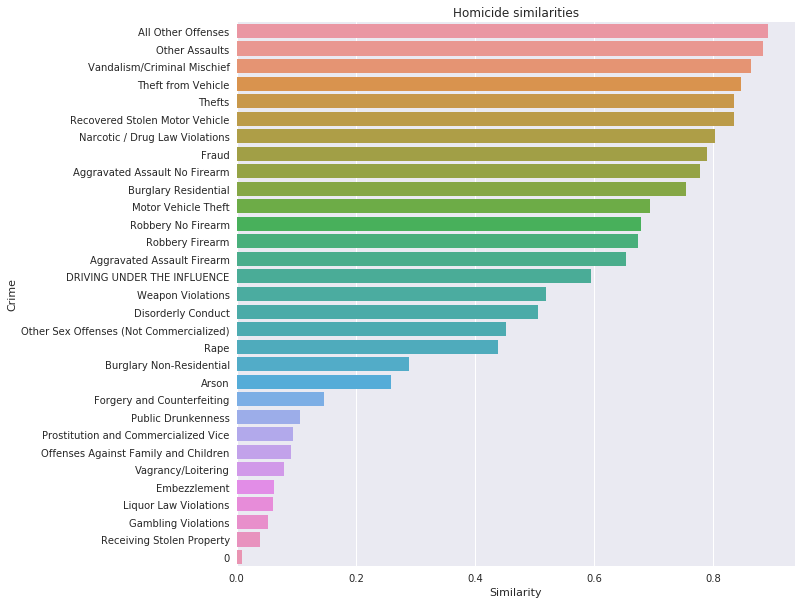

In [30]:
similarities_df = pd.DataFrame(data=similarities, columns=['Similarity'])
similarities_df.index.name = "Crime"

ax = similarities_df.plot(kind='barh', legend=False, width=.5, figsize=(10,10))
sns.barplot(x=similarities_df.Similarity, y=similarities_df.index)
plt.title("Homicide similarities")
plt.show()